<a href="https://colab.research.google.com/github/CAVASOL/aiffel_node/blob/master/dl_project/dl_master_project_reuters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DL Master node 10. Reuters

**학습 목표**

* Reuters 데이터넷을 이용해 텍스트로 구성된 뉴스 데이터의 주제를 분류하는 딥러닝 모델을 실습합니다.

**데이터 로드 및 전처리**

* reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다. 데이터셋은 keras.datasets에서 불러올 수 있는 reuters 데이터 셋을 활용하고, 이때 파라메터 조정을 통해 단어의 개수는 10000개로 제한합니다(num_words=10000).
* 데이터셋 분리 작업에서는 sklearn 라이브러리의 train_test_split 함수를 활용합니다.
* 훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력합니다.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [ ]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.

from keras.datasets import reuters
from sklearn.model_selection import train_test_split

(x_train_full, y_train_full), (test_data, test_label) = reuters.load_data(num_words = 10000)
(train_data, val_data, train_label, val_label) = train_test_split(x_train_full,
                                                                  y_train_full,
                                                                  test_size = 0.25,
                                                                  random_state = 2023)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(len(train_data))
print(len(val_data))
print(len(val_label))
print(len(test_data))

print(len(set(y_train_full)))

6736
2246
2246
2246
46


텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다. 원-핫 인코딩 함수를 적용합니다. 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.

In [ ]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.
from tensorflow.keras import utils

def one_hot_encoding(data, dim=10000):
  results = np.zeros((len(data), dim))
  for i, d in enumerate(data):
    results[i, d] = 1.
  return results

x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
y_train = utils.to_categorical(train_label)
y_val = utils.to_categorical(val_label)
y_test = utils.to_categorical(test_label)

print(y_train.shape)

(6736, 46)


**모델 구성 및 컴파일**

BatchNormalization과 Dropout을 적용하여 빠르게 학습하면서 과대적합을 방지하고, 46개의 뉴스 주제를 분류하는 딥러닝 모델을 구성합니다.

In [ ]:
# # 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(128, input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(128, name='hidden'))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax', name='output'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model.save('reuters_model_init')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 128)               1280128   
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
hidden (Dense)               (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 46)                5934      
Total params: 1,303,086
Trainable params: 1,302,830
Non-trainable params: 256
____________________________________________

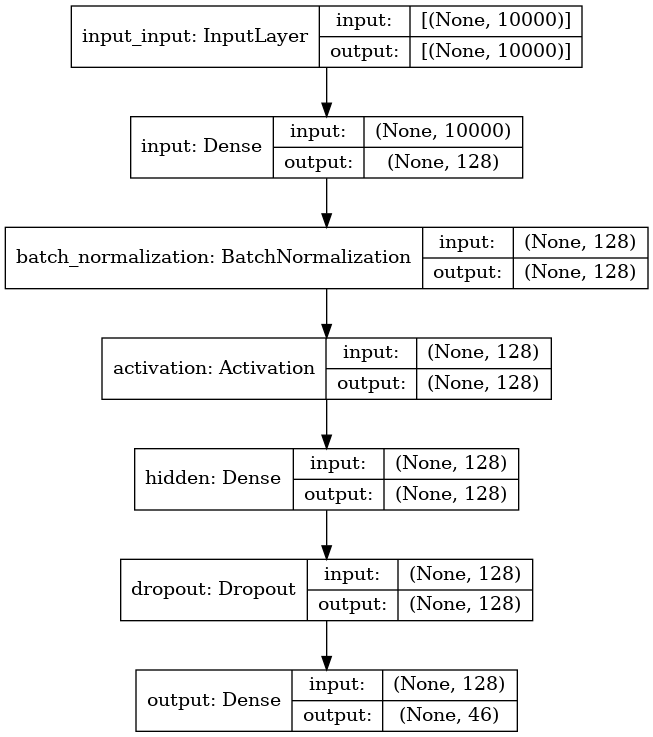

In [ ]:
from tensorflow.keras import utils

utils.plot_model(model, show_shapes=True)

**모델 학습**

In [ ]:
# 문제 1-3: 예측을 위한 딥러닝 모델을 학습합니다.
from tensorflow.keras import callbacks

check_point_cb = callbacks.ModelCheckpoint('reuters_model.h5',
                                           monitor="val_loss",
                                           save_best_only=True)

early_stopping_cb = callbacks.EarlyStopping(patience=10,
                                            monitor="val_loss",
                                            restore_best_weights=True)

history = model.fit(x_train, y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/40
14/14 [==============================] - 2s 47ms/step - loss: 2.3462 - accuracy: 0.4786 - val_loss: 2.8770 - val_accuracy: 0.6683
Epoch 2/40
14/14 [==============================] - 0s 16ms/step - loss: 1.0547 - accuracy: 0.7503 - val_loss: 2.5721 - val_accuracy: 0.7529
Epoch 3/40
14/14 [==============================] - 0s 16ms/step - loss: 0.7130 - accuracy: 0.8382 - val_loss: 2.5059 - val_accuracy: 0.7796
Epoch 4/40
14/14 [==============================] - 0s 16ms/step - loss: 0.4885 - accuracy: 0.8980 - val_loss: 2.3263 - val_accuracy: 0.8010
Epoch 5/40
14/14 [==============================] - 0s 15ms/step - loss: 0.3440 - accuracy: 0.9255 - val_loss: 2.1716 - val_accuracy: 0.8014
Epoch 6/40
14/14 [==============================] - 0s 16ms/step - loss: 0.2545 - accuracy: 0.9430 - val_loss: 2.0155 - val_accuracy: 0.8019
Epoch 7/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1958 - accuracy: 0.9547 - val_loss: 1.8323 - val_accuracy: 0.8045
Epoch 8/40
14

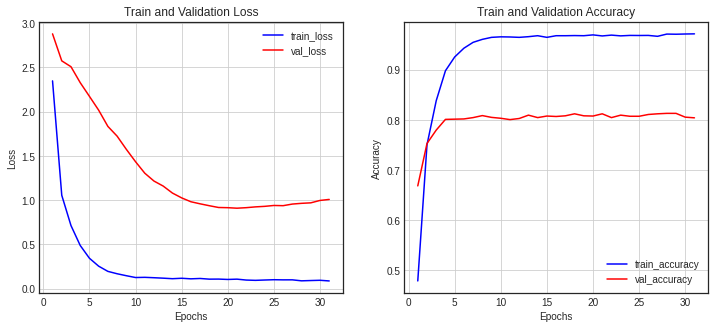

In [ ]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.

plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

**모델 평가 및 예측**

In [ ]:
# 문제 2-5: 테스트 데이터셋을 이용해 모델을 평가합니다.

print(model.evaluate(x_test, y_test))

71/71 [==============================] - 0s 2ms/step - loss: 0.9672 - accuracy: 0.8050
[0.967168927192688, 0.8049866557121277]
